In [1]:
from config import TrainConfig, InferenceConfig
from train import ModelConfig, get_data, get_model, trainer
from inference import InfConfig, get_trained_model_config, get_trained_model, denoise_data
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import os
import pandas as pd
import tifffile

# Train model

Entire model training is handled by `train_config` so we define it first. To see a list of parameters that can be defined in `train_config` we can take a look at attributes in `default_config`

In [2]:
default_config = TrainConfig()
vars(default_config)

{'data': [],
 'out': '',
 'run': 1,
 'max_proj': 1,
 'arch': 'hourglass_wres',
 'mode': '2D',
 'depth': 1,
 'loss': 'l1',
 'epochs': 150,
 'lr': 0.001,
 'bs': 6,
 'tsize': 0}

Let's define our `train_config`. Here we will train `unet_fixed` architecture with `l2` loss on `data`. Our `data` consists of 2D images thus `mode` is set as `2D` and `depth` as `1`.<br>
Please take a look at `/data/` folder to see structure of input data folders. Within the `data` folder, all high SNR images should be present in `gt_imgs` folder and all noisy images should be present in `noisy_imgs` folder.<br> The images may be 2D or 3D.

In [3]:
train_config = {
    'data': ['/home/schaudhary/whole-brain_DeepDenoising/data/synthetic_data/signal_5'],
    'arch': 'unet_fixed',
    'epochs': 2,
    'mode': '2D',
    'depth': 1,
    'loss': 'l2'
}

In [4]:
model_config = ModelConfig(train_config)

Confirm the parameters of `model_config`

In [5]:
vars(model_config)

{'data': ['/home/schaudhary/whole-brain_DeepDenoising/data/synthetic_data/signal_5'],
 'out': '',
 'run': 1,
 'max_proj': 1,
 'arch': 'unet_fixed',
 'mode': '2D',
 'depth': 1,
 'loss': 'l2',
 'epochs': 2,
 'lr': 0.001,
 'bs': 6,
 'tsize': 0}

Next, let's take a look some examples images from training data

In [6]:
train_X, train_Y, test_X, test_Y, tsize = get_data(model_config)
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(335, 1, 512, 512)
(335, 1, 512, 512)
(165, 1, 512, 512)
(165, 1, 512, 512)


Text(0.5, 1.0, 'gt')

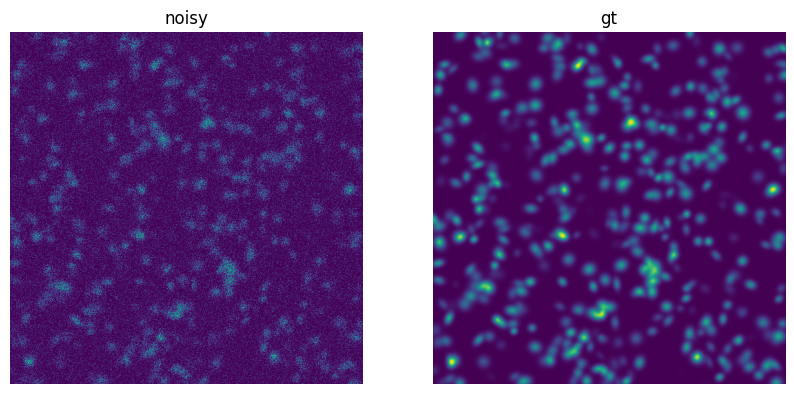

In [7]:
idx = np.random.randint(0, train_X.shape[0])
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(train_X[idx, 0, :, :])
ax[0].axis('off')
ax[0].set_title('noisy')
ax[1].imshow(train_Y[idx, 0, :, :])
ax[1].axis('off')
ax[1].set_title('gt')

Next let's take a look at `model` architecture and summary that is going to be used for training.

NOTE - this step is not necessary as configuring `model` is automatically taken care of by `trainer` during training (see next steps).

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = get_model(model_config, device, in_channels=train_X.shape[1])

In [10]:
c, h, w = train_X.shape[1], train_X.shape[2], train_X.shape[3]
summary(model, (c, h, w))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             320
              ReLU-2         [-1, 32, 512, 512]               0
            Conv2d-3         [-1, 32, 512, 512]           9,248
              ReLU-4         [-1, 32, 512, 512]               0
            Conv2d-5         [-1, 32, 512, 512]           9,248
              ReLU-6         [-1, 32, 512, 512]               0
         ConvBlock-7  [[-1, 32, 512, 512], [-1, 32, 512, 512], [-1, 32, 512, 512]]               0
         MaxPool2d-8         [-1, 32, 256, 256]               0
            Conv2d-9         [-1, 32, 256, 256]           9,248
             ReLU-10         [-1, 32, 256, 256]               0
           Conv2d-11         [-1, 32, 256, 256]           9,248
             ReLU-12         [-1, 32, 256, 256]               0
           Conv2d-13         [-1, 32, 256, 256]           9,248
    

/home/schaudhary/anaconda3/envs/niddl-env/lib/python3.9/site-packages/torchsummary/torchsummary.py:93: RuntimeWarning: overflow encountered in scalar add
  total_output += np.prod(summary[layer]["output_shape"])


Now, we train the model

In [11]:
trainer(model_config)

'Starting training'
{'arch': 'unet_fixed',
 'bs': 6,
 'data': ['/home/schaudhary/whole-brain_DeepDenoising/data/synthetic_data/signal_5'],
 'depth': 1,
 'epochs': 2,
 'loss': 'l2',
 'lr': 0.001,
 'max_proj': 1,
 'mode': '2D',
 'out': '',
 'run': 1,
 'tsize': 0}
epoch: 0, Train Loss: 0.021759407594799995, Test Loss: 0.021912239491939545
epoch: 1, Train Loss: 0.017397839576005936, Test Loss: 0.01682628132402897
saved model config at run_unet_fixed_l2_mp1_m2D_d1_1_0/model_config.pickle
saved model weights at run_unet_fixed_l2_mp1_m2D_d1_1_0/model_weights.pt
saving denoising on random test examples


# Output of trained model

In this section we will take a look at output files saved once training is finished. Several files are generated during training - <br>
1. `model_config.pickle` - this file stores the `model_config` i.e. all training parameters used for training.<br>
2. `model_weights.pt` - this file stores the trained model weights.<br>
3. `training_loss.txt` - this file stores the epoch wise training loss.<br>
4. `test_data_loss.txt` - this file stores the loss value calulated on atmost 150 random images selected from test set i.e. `test_X`.
5. `X_*.png`, `Y_*.png` and `pred_*.png` - ground truth, noisy and denoised image prediction by model on 10 random images from test set. These can be used to visualize model denoising performance. 

In [12]:
run_path = '/home/schaudhary/whole-brain_DeepDenoising/test_runs/run_unet_fixed_l1_mp1_m2D_d1_1_0'

In [13]:
training_loss = pd.read_csv(os.path.join(run_path, 'training_loss.txt'), delimiter=',', header=None, names=['epoch', 'train_loss', 'test_loss', 'epoch_time', 'depth', 'run', 'tsize'])
training_loss

epoch  train_loss  test_loss   epoch_time  depth  run  tsize
0       0    0.061083   0.057772  1123.191752      1    1      0
1       1    0.052493   0.054354  1126.173025      1    1      0
2       2    0.050812   0.048843  1127.644712      1    1      0
3       3    0.053188   0.052533  1125.405357      1    1      0
4       4    0.047838   0.045918  1128.460915      1    1      0
5       5    0.044163   0.043422  1128.111305      1    1      0
6       6    0.042201   0.043307  1127.227892      1    1      0
7       7    0.041822   0.039148  1126.661922      1    1      0
8       8    0.044254   0.044041  1126.417340      1    1      0
9       9    0.040061   0.040254  1125.573031      1    1      0
10     10    0.042129   0.043504  1127.686203      1    1      0
11     11    0.039633   0.037726  1126.819171      1    1      0
12     12    0.040573   0.039305  1126.428812      1    1      0
13     13    0.041964   0.040927  1126.596821      1    1      0
14     14    0.039584   0.038701  1126.582984      1    1      0
15     15    0.039337   0.037873  1126.368808      1    1      0
16     16    0.037685   0.040378  1124.671536      1    1      0
17     17    0.038827   0.037301  1125.589119      1    1      0
18     18    0.037923   0.038994  1126.534047      1    1      0
19     19    0.037500   0.037349  1127.912740      1    1      0
20     20    0.038523   0.036069  1127.640717      1    1      0
21     21    0.037252   0.036404  1127.637375      1    1      0
22     22    0.039170   0.039177  1126.401753      1    1      0
23     23    0.038282   0.037102  1126.301632      1    1      0
24     24    0.037873   0.037096  1127.127280      1    1      0
25     25    0.035539   0.037281  1126.498103      1    1      0
26     26    0.039066   0.038525  1125.494820      1    1      0
27     27    0.035796   0.036620  1125.600011      1    1      0
28     28    0.036607   0.035418  1127.567327      1    1      0
29     29    0.035470   0.035468  1126.976471      1    1      0

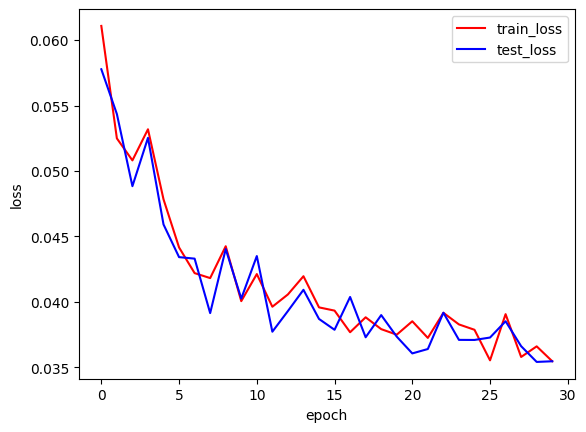

In [14]:
fig, ax = plt.subplots(1, 1)
ax.plot(training_loss['epoch'], training_loss['train_loss'], 'r')
ax.plot(training_loss['epoch'], training_loss['test_loss'], 'b')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(labels=['train_loss', 'test_loss'])

In [15]:
test_data_loss = pd.read_csv(os.path.join(run_path, 'test_data_loss.txt'), delimiter=',', header=None, names=['index', 'image_index', 'loss', 'inference_time(s)', 'depth', 'run', 'tsize'])
test_data_loss

index  image_index      loss  inference_time(s)  depth  run  tsize
0        0           60  0.029961           0.823272      1    1      0
1        1           88  0.030932           0.817034      1    1      0
2        2          109  0.042527           0.817568      1    1      0
3        3          105  0.025871           0.829795      1    1      0
4        4          161  0.046013           0.816618      1    1      0
..     ...          ...       ...                ...    ...  ...    ...
145    145            9  0.025278           0.822662      1    1      0
146    146          118  0.038206           0.816271      1    1      0
147    147           97  0.034088           0.822258      1    1      0
148    148          130  0.027125           0.823061      1    1      0
149    149           51  0.041094           0.816214      1    1      0

[150 rows x 7 columns]

Let's take a look at denoising performance of trained model. We will plot all predictions in `run_path`

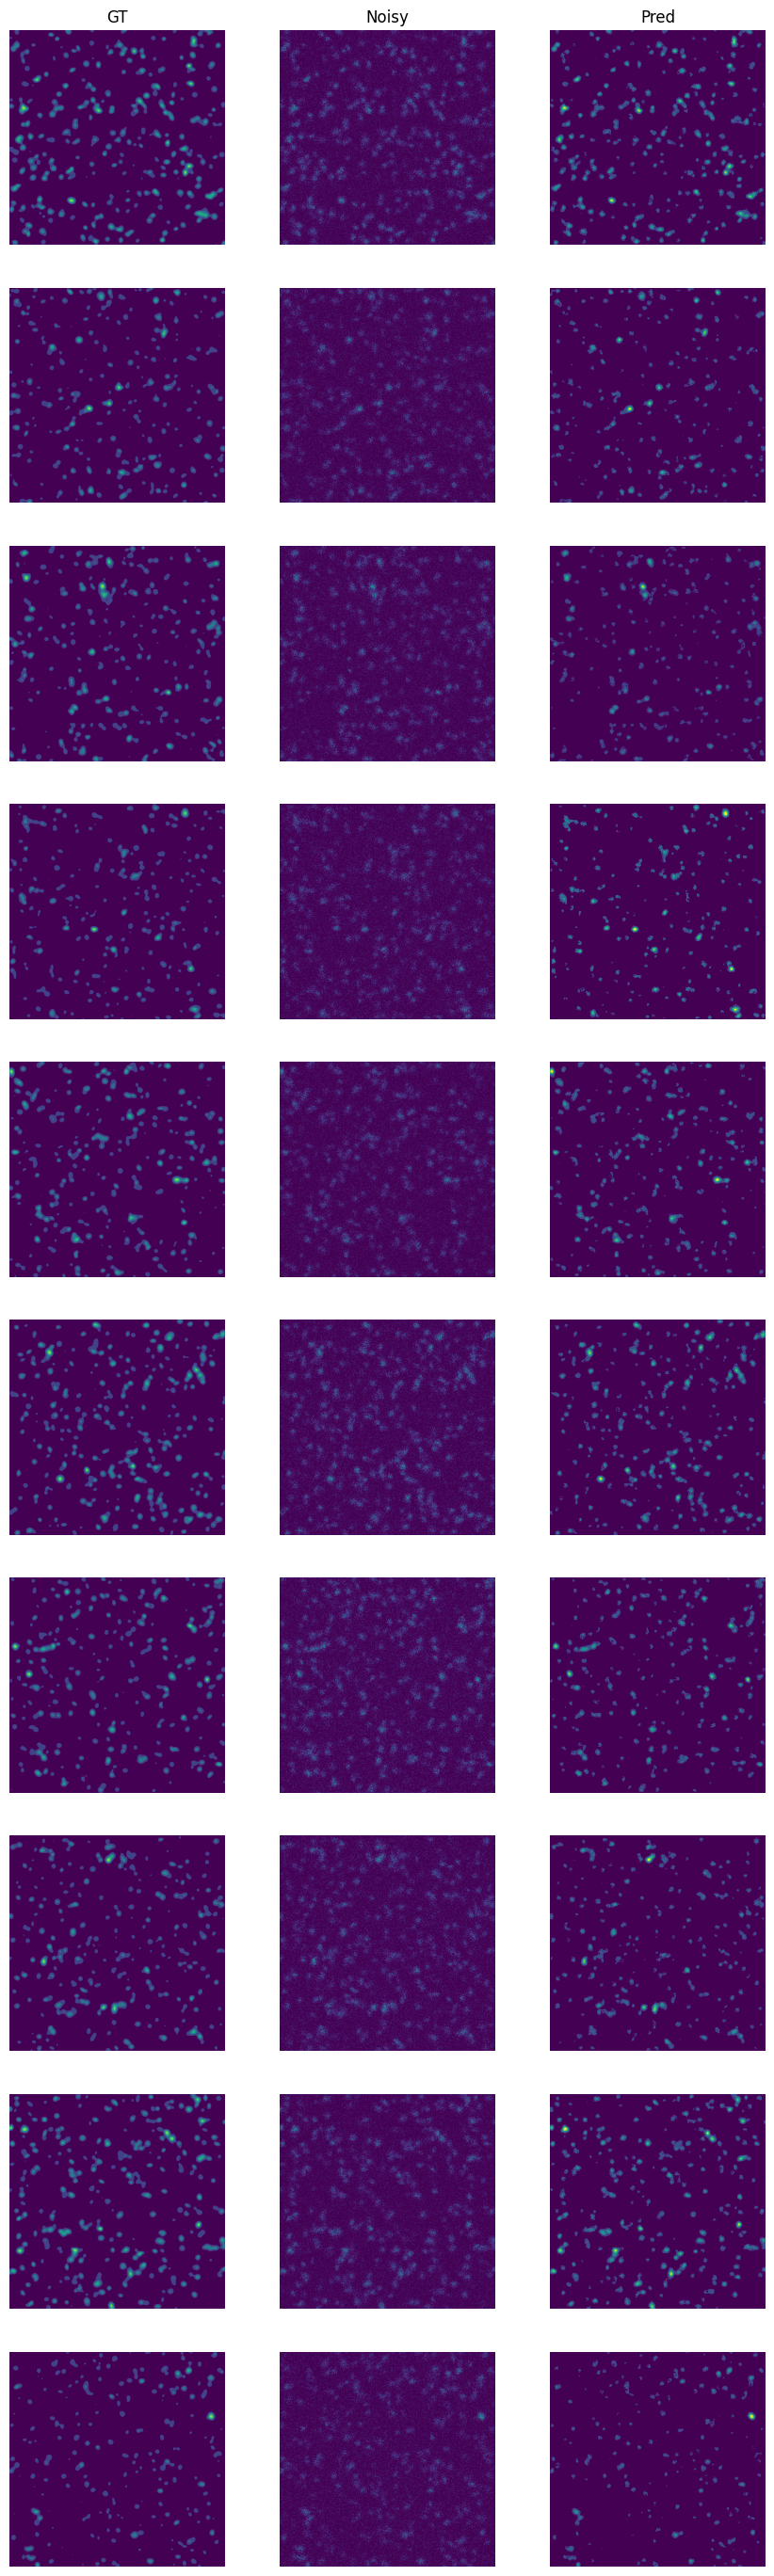

In [19]:
noisy_images = [f for f in os.listdir(run_path) if f.startswith('X_')]
gt_images = [f'Y{f[1::]}' for f in noisy_images]
denoised_images = [f'pred{f[1::]}' for f in noisy_images]

fig, ax = plt.subplots(len(noisy_images), 3, figsize=(3.5*3, 3.5*len(noisy_images)))
for i, img in enumerate(noisy_images):
    curr_noisy_img = cv2.imread(os.path.join(run_path, img), -1)
    curr_gt_img = cv2.imread(os.path.join(run_path, gt_images[i]), -1)
    curr_pred_img = cv2.imread(os.path.join(run_path, denoised_images[i]), -1)

    ax[i, 0].imshow(curr_gt_img)
    ax[i, 1].imshow(curr_noisy_img)
    ax[i, 2].imshow(curr_pred_img)
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')

    if i == 0:
        ax[i, 0].set_title('GT')
        ax[i, 1].set_title('Noisy')
        ax[i, 2].set_title('Pred')

# Denoising using trained model

Inference is handled by `inference_config` so we define it first. To see a list of parameters that can be defined in `inference_config` we can take a look at attributes in `default_inference_config`.

In [2]:
default_inference_config = InferenceConfig()
vars(default_inference_config)

{'data': [], 'run': ''}

Next we define `inference_config`. It requires two inputs.<br> 
1. `data`: that is a list of all data folders to be denoised. Please take a look at `/data/` folder to see structure of input data folders. All noisy images within data folder should be present in `noisy_imgs` folder.<br>
2. `run`: that is the path for trained model to use for denoising

In [3]:
inference_config = {
    'data': [
        '/home/schaudhary/whole-brain_DeepDenoising/data/synthetic_data/test_signal_5/',
    ],
    'run': '/home/schaudhary/whole-brain_DeepDenoising/test_runs/run_unet_fixed_l1_mp1_m2D_d1_1_0'
}

In [4]:
inference_config = InfConfig(inference_config)

Let's confirm the parameters in `inference_config`

In [5]:
vars(inference_config)

{'data': ['/home/schaudhary/whole-brain_DeepDenoising/data/synthetic_data/test_signal_5/'],
 'run': '/home/schaudhary/whole-brain_DeepDenoising/test_runs/run_unet_fixed_l1_mp1_m2D_d1_1_0'}

Next we get `trained_model_config` and `trained_model`.

In [6]:
trained_model_config = get_trained_model_config(inference_config)
trained_model = get_trained_model(inference_config, trained_model_config)

`trained_model_config` can be used to remind us of what parameters were used for this model training.

In [7]:
vars(trained_model_config)

{'data': ['/home/schaudhary/whole-brain_DeepDenoising/data/synthetic_data/signal_5'],
 'out': '/home/schaudhary/whole-brain_DeepDenoising/test_runs',
 'run': 1,
 'max_proj': 1,
 'arch': 'unet_fixed',
 'mode': '2D',
 'depth': 1,
 'loss': 'l1',
 'epochs': 30,
 'lr': 0.001,
 'bs': 6,
 'tsize': 0,
 'in_channels': 1,
 'out_channels': 32}

Next, denoise images.<br>
NOTE - make sure to delet `pred_imgs` folders (if present) from `/home/schaudhary/whole-brain_DeepDenoising/data/synthetic_data/test_signal_5/noisy_imgs` to not mess up image reading

In [8]:
denoise_data(inference_config, trained_model_config, trained_model)

  0%|          | 0/1 [00:00<?, ?it/s]

Denoising /home/schaudhary/whole-brain_DeepDenoising/data/synthetic_data/test_signal_5/


100%|██████████| 1/1 [00:06<00:00,  6.94s/it]


Lets take a look at how well denoising model performed

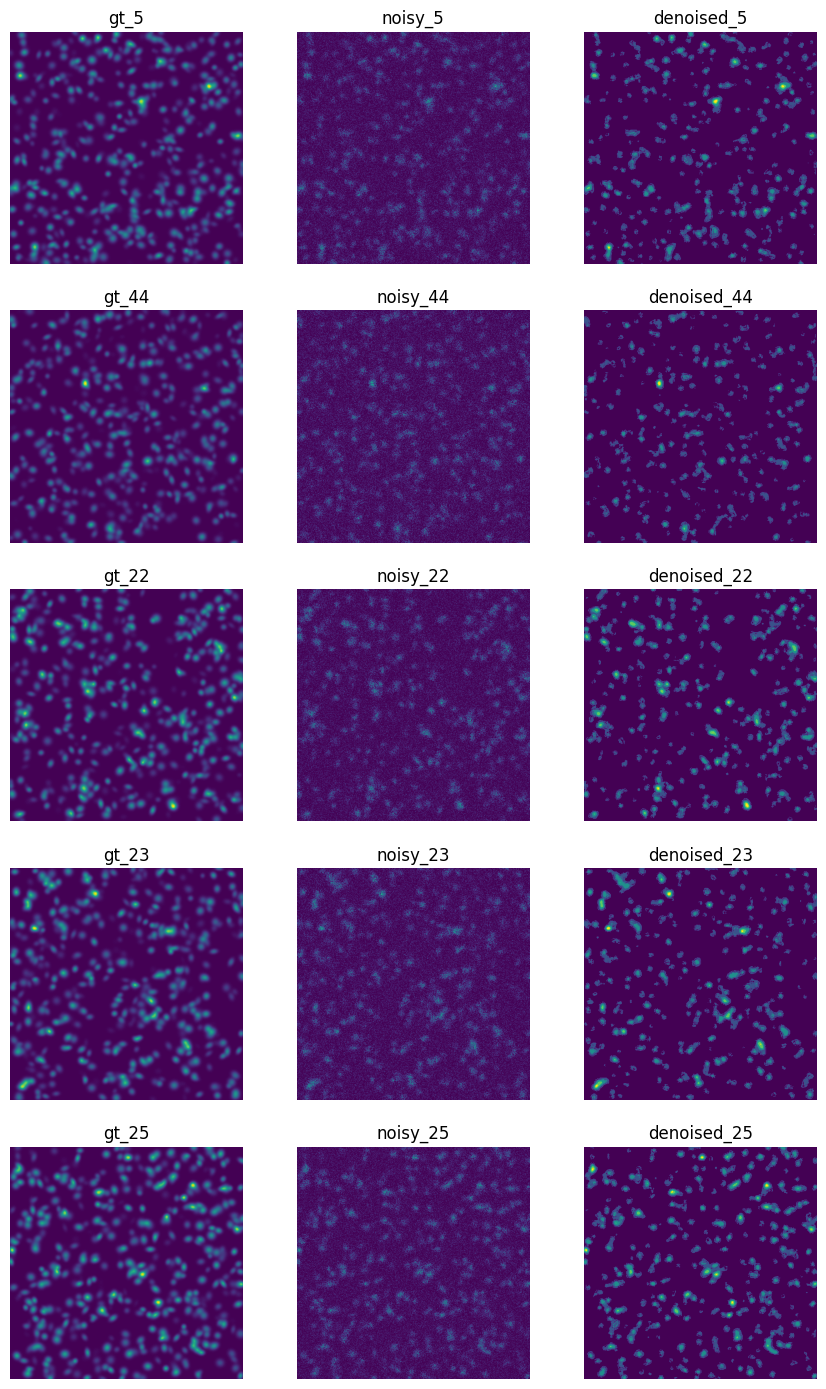

In [9]:
gt_img_path = os.path.join(inference_config.data[0], 'gt_imgs')
noisy_img_path = os.path.join(inference_config.data[0], 'noisy_imgs')
denoised_img_path = os.path.join(inference_config.data[0], 'pred_model')

num_test_imgs = len(os.listdir(gt_img_path))
num_samples = 5
random_imgs = np.random.randint(1, num_test_imgs, num_samples)

fig, axs = plt.subplots(num_samples, 3, figsize=(3.5*3, 3.5*num_samples))
for i, idx in enumerate(random_imgs):
    curr_gt_img = cv2.imread(os.path.join(gt_img_path, f'img_{idx}.tif'), -1)
    curr_noisy_img = cv2.imread(os.path.join(noisy_img_path, f'img_{idx}.tif'), -1)
    curr_denoised_img = cv2.imread(os.path.join(denoised_img_path, f'img_{idx}.tif', 'z_1.tif'), -1)

    # curr_gt_img = tifffile.imread(os.path.join(gt_img_path, f'img_{idx}.tif'))
    # curr_noisy_img = tifffile.imread(os.path.join(noisy_img_path, f'img_{idx}.tif'))
    # curr_denoised_img = tifffile.imread(os.path.join(denoised_img_path, f'img_{idx}', 'z_1.tif'))

    axs[i, 0].imshow(curr_gt_img)
    axs[i, 1].imshow(curr_noisy_img)
    axs[i, 2].imshow(curr_denoised_img)
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    axs[i, 2].axis('off')
    # if i == 0:
    axs[i, 0].set_title(f'gt_{idx}')
    axs[i, 1].set_title(f'noisy_{idx}')
    axs[i, 2].set_title(f'denoised_{idx}')

Instead of denoising whole image folders, individual images can also be denoised by providing their in `inference_config`

In [7]:
inference_config = {
    'data': [
        '/home/schaudhary/whole-brain_DeepDenoising/data/synthetic_data/test_signal_5/noisy_imgs/img_1.tif',
        '/home/schaudhary/whole-brain_DeepDenoising/data/synthetic_data/test_signal_5/noisy_imgs/img_2.tif',
        '/home/schaudhary/whole-brain_DeepDenoising/data/synthetic_data/test_signal_5/noisy_imgs/img_3.tif',
        '/home/schaudhary/whole-brain_DeepDenoising/data/synthetic_data/test_signal_5/noisy_imgs/img_4.tif',
        '/home/schaudhary/whole-brain_DeepDenoising/data/synthetic_data/test_signal_5/noisy_imgs/img_5.tif',
    ],
    'run': '/home/schaudhary/whole-brain_DeepDenoising/test_runs/run_unet_fixed_l1_mp1_m2D_d1_1_0'
}

In [8]:
inference_config = InfConfig(inference_config)
trained_model_config = get_trained_model_config(inference_config)
trained_model = get_trained_model(inference_config, trained_model_config)

In [9]:
denoise_data(inference_config, trained_model_config, trained_model)

  0%|          | 0/5 [00:00<?, ?it/s]

Denoising /home/schaudhary/whole-brain_DeepDenoising/data/synthetic_data/test_signal_5/noisy_imgs/img_1.tif


 60%|██████    | 3/5 [00:13<00:07,  3.61s/it]

Denoising /home/schaudhary/whole-brain_DeepDenoising/data/synthetic_data/test_signal_5/noisy_imgs/img_2.tif
Denoising /home/schaudhary/whole-brain_DeepDenoising/data/synthetic_data/test_signal_5/noisy_imgs/img_3.tif
Denoising /home/schaudhary/whole-brain_DeepDenoising/data/synthetic_data/test_signal_5/noisy_imgs/img_4.tif


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]

Denoising /home/schaudhary/whole-brain_DeepDenoising/data/synthetic_data/test_signal_5/noisy_imgs/img_5.tif


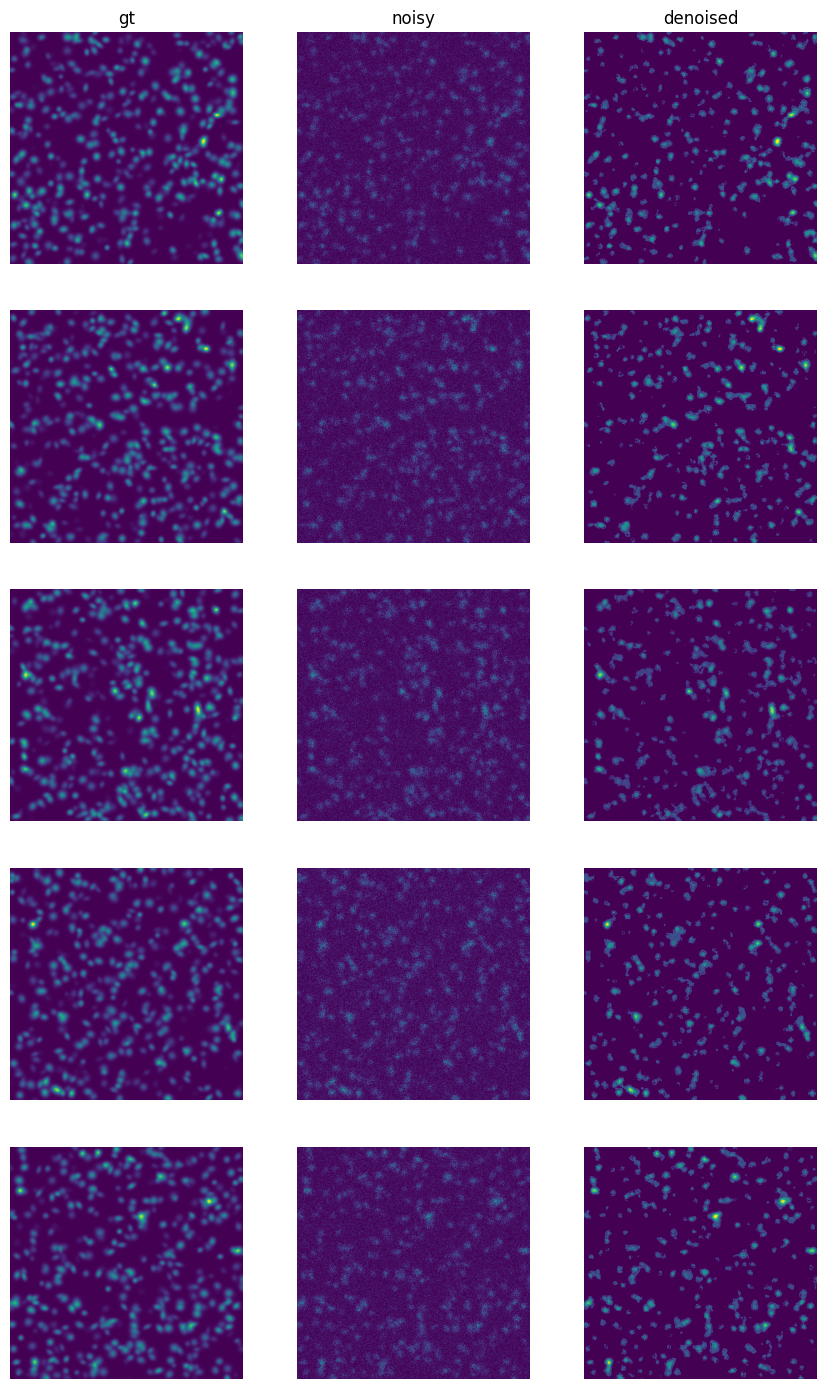

In [9]:
num_samples = 5
fig, axs = plt.subplots(num_samples, 3, figsize=(3.5*3, 3.5*num_samples))
for i, img in enumerate(inference_config.data):
    path_split = img.split(os.sep)
    curr_gt_img_path = os.path.join(os.path.sep, *path_split[0:len(path_split)-2], 'gt_imgs', path_split[-1])
    curr_denoised_img_path = os.path.join(os.path.sep, *path_split[0:len(path_split)-1], f'pred_{path_split[-1]}', f'{path_split[-1]}.tif')
    
    curr_gt_img = tifffile.imread(curr_gt_img_path)
    curr_noisy_img = tifffile.imread(img)
    curr_denoised_img = tifffile.imread(curr_denoised_img_path)

    axs[i, 0].imshow(curr_gt_img)
    axs[i, 1].imshow(curr_noisy_img)
    axs[i, 2].imshow(curr_denoised_img)
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    axs[i, 2].axis('off')
    if i == 0:
        axs[i, 0].set_title('gt')
        axs[i, 1].set_title('noisy')
        axs[i, 2].set_title('denoised')

Note make sure to detele `pred_imgs` folders from `/home/schaudhary/whole-brain_DeepDenoising/data/synthetic_data/test_signal_5/noisy_imgs` to not mess up image reading